In [1]:
import sys
import os

# # Simple approach: add the parent directory to Python path
# project_root = os.path.dirname(os.getcwd())
# sys.path.insert(0, project_root)
# print(f"Added {project_root} to Python path")
# print(f"Current working directory: {os.getcwd()}")

import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_v3_filling_1p5_t_4_em4_random_basis_mesh_60.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(9.999685940398351e-08)

In [4]:
np.max(final_e_difference)

np.float64(9.922820343177818e-09)

### Phase Analysis

In [5]:
from functions_parameters.tools import rot_symm_m_check_d
from functions_parameters.universal_parameters import pauli_matrices

c_6 = np.array([[0,0,1],
               [1,0,0],
               [0,1,0]])
c_3 = c_6@c_6
c_2 = c_6 @ c_3

In [6]:
nematic_phase = ['R symmetric', 'C3 charge nematic', 'C2 charge nematic', 'no R']
Magnetism_phase = [' +', ' FM', ' Ferri', ' AFM']

phase_list_final = list(i+j for i,j in product(nematic_phase, Magnetism_phase))

In [7]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [8]:
threshold = 1E-2

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
gs_m = np.zeros(u_mesh.shape)
gs_n = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording = np.zeros((4))
        m_recording = np.zeros((4))
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
        gs_n[i,j] = c6_diff
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        # else:
        #     rs_recording[3] = 1
        gs_m[i,j] = np.max(np.abs(magnetism_arr))
        if np.max(np.abs(magnetism_arr)) > threshold:
            if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
                m_recording[1] = 1
            else:
                net_m = np.sum(magnetism_arr)
                if np.abs(net_m) < threshold:
                    m_recording[3] = 1
                else:
                    m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(rs_recording,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        # it this right???????
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

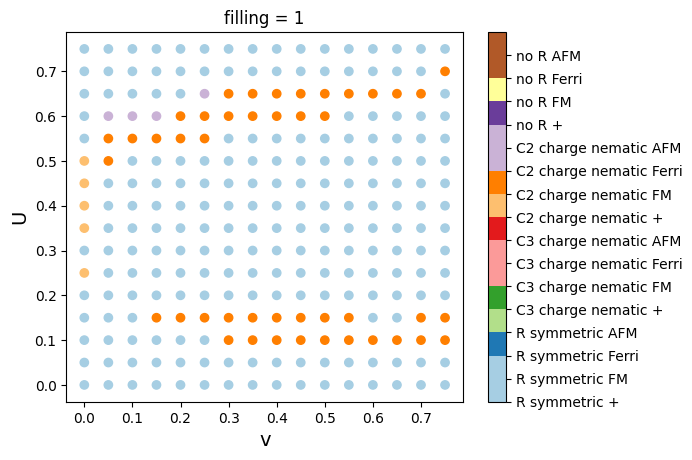

In [9]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(u_mesh, v1_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [10]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

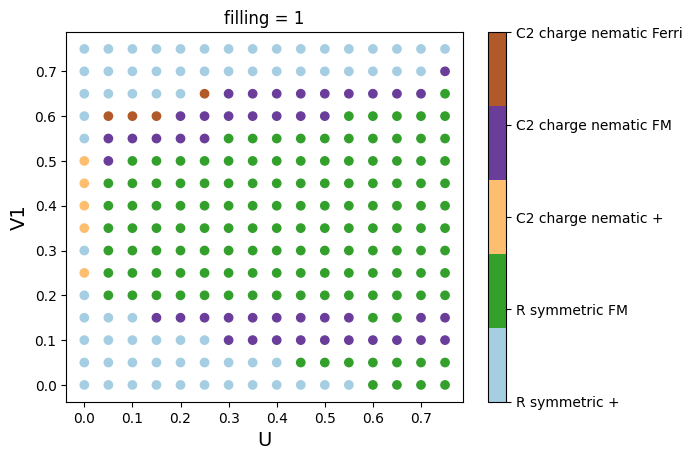

In [11]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(u_mesh, v1_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('U', size = '14')
plt.ylabel('V1', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

Text(0.5, 1.0, 'filling = 3/4')

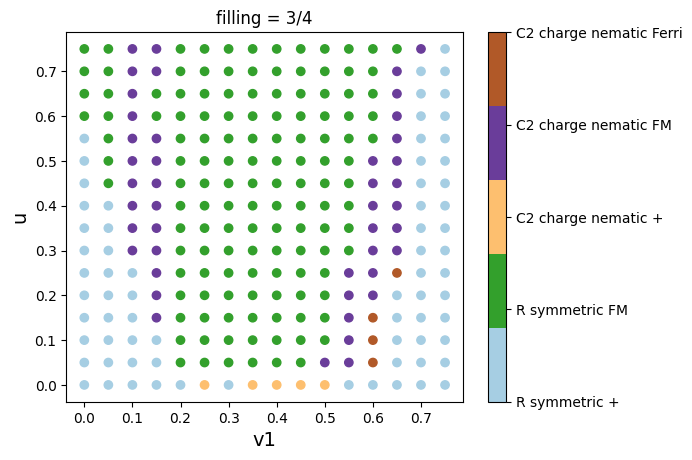

In [12]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 3/4')

In [13]:
sorted_ground_state_e[-3,-1]

array([-0.29248843, -0.29248843, -0.29248842, -0.29248842, -0.29248827,
       -0.29248827, -0.29248827, -0.29248827, -0.29248827, -0.29248827])

In [14]:
sorted_density[-3,-1,0,0]

array([0.25000006-6.23876200e-26j, 0.25      +9.11137521e-20j,
       0.24999994+1.84161329e-19j])

In [15]:
sorted_ground_state_e[-9,-1]

array([-0.29248843, -0.29248843, -0.29248843, -0.29248843, -0.29248843,
       -0.29248843, -0.29248843, -0.29248843, -0.29248843, -0.29248842])

In [16]:
sorted_density[-9,-1,0]

array([[0.25000054+1.96962990e-24j, 0.25000054+1.71327437e-19j,
        0.25000018+6.63998523e-20j],
       [0.24999946+1.30344873e-24j, 0.24999946+1.12258106e-21j,
        0.24999983+2.29232833e-19j]])

In [17]:
sorted_density[-9,-1,-1]

array([[0.25000056-1.82038406e-25j, 0.25000056+1.65352366e-19j,
        0.25000056+3.13059017e-20j],
       [0.24999944+3.25870620e-25j, 0.24999944+6.75640567e-20j,
        0.24999944+1.10783628e-19j]])

In [18]:
sorted_density[-3,-1,4,0]

array([0.25118308-3.34383950e-25j, 0.25069695+8.88907972e-20j,
       0.25069693-3.73842993e-20j])

In [19]:
sorted_density[-3,-1,4,1]

array([0.249035  +9.60062449e-26j, 0.24919401-2.81698415e-19j,
       0.24919402-1.28960389e-20j])

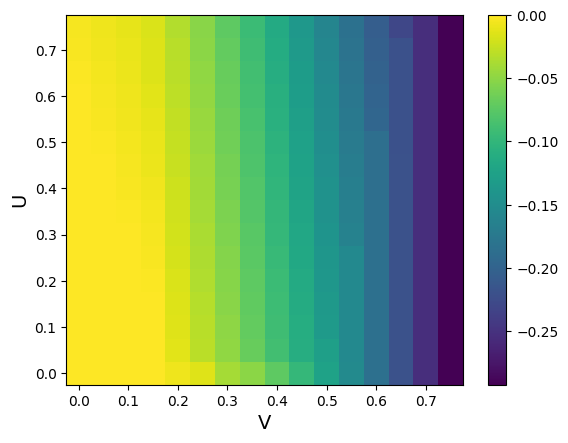

In [20]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

Text(0.5, 1.0, 'ground state c_6_diff')

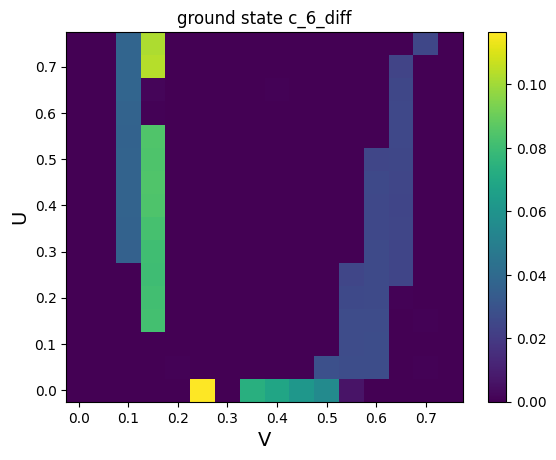

In [21]:
plt.pcolormesh(v1_mesh,u_mesh,gs_n)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state c_6_diff')

Text(0.5, 1.0, 'ground state max magnetization')

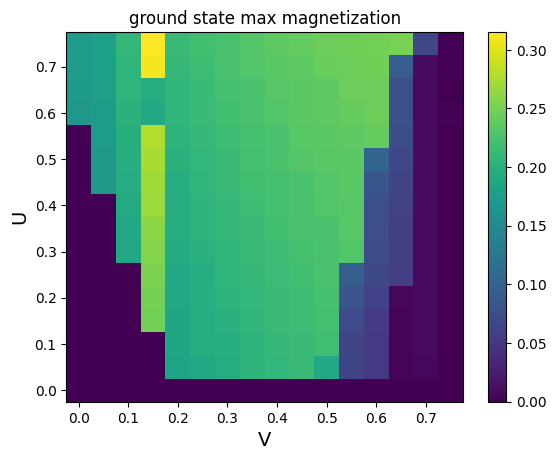

In [22]:
plt.pcolormesh(v1_mesh,u_mesh,gs_m)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

In [23]:
sorted_density[0,-1,0]

array([[0.24999996+4.52827619e-26j, 0.24999996-2.69826373e-20j,
        0.25000007+1.45648376e-19j],
       [0.24999996+4.52827619e-26j, 0.24999996-2.69826373e-20j,
        0.25000007+1.45648376e-19j]])

In [24]:
sorted_density[0,-1,1]

array([[0.24999996+9.05997467e-23j, 0.25000008-4.22183833e-20j,
        0.24999997-7.44541272e-20j],
       [0.24999996+9.05997467e-23j, 0.25000008-4.22183833e-20j,
        0.24999997-7.44541272e-20j]])

In [25]:
final_bond[0,-1,0].shape

(9, 2, 3, 3, 3)

In [26]:
import jax
import jax.numpy as jnp
import numpy as np
import os
from itertools import product

from functions_parameters.jax_schf_kernel import schf_fixed_filling_pmap_over_u, schf_single_job
from functions_parameters.jax_schf_helpers import *
from functions_parameters.universal_parameters import a, b
from functions_parameters.bond_table_generator import build_buckets_per_shell

# ---- numeric mode ----
from jax import config as _jax_config
_jax_config.update("jax_enable_x64", True)  # use float64 by default

Array = jnp.ndarray
PyTree = Any

'''
preparation:
'''
# order is important. for sublattice a, b and c respectively
basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
norb = basis_frac.shape[0]
num_k_mesh = 60
b_0 = np.linspace(-b[0] / 2, b[0] / 2, num_k_mesh, endpoint=False)
b_1 = np.linspace(-b[1] / 2, b[1] / 2, num_k_mesh, endpoint=False)
k_mesh_points = np.vstack([v1 + v2 for v1, v2 in product(b_0, b_1)])
num_k_points = k_mesh_points.shape[0]

nshell_tb = 2
radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, nshell_tb)

# in this case, as both TB model and interaction, we include up to NNN, the a_list and deltas are the same
# calculate the correlation matrix
temperature = 4E-4
filling = 3/4
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_mesh_points)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)

# generate data for ref_state wrt interaction neighbors
nshell_v = 3
radii_v, a_lists_v, deltas_v = build_buckets_per_shell(a, basis_frac, nshell_v)
phase_pos_v, phase_neg_v = precompute_k_phase_tables(deltas_v, a, k_mesh_points)
dict_ref = prepare_reference_state(filling, a_lists_v, Htb, e_all, v_all, v_all_dagger, phase_pos_v, phase_neg_v, temperature)



In [27]:
dict_ref['e_fermi']

Array(-0.00696942, dtype=float64)

In [28]:
dict_ref['e_u_o']

Array(0.1875, dtype=float64)

In [29]:
dict_ref['e_v_o_arr']

Array([1.31252039, 1.28953656, 2.13592464], dtype=float64)

In [30]:
dict_ref_ref = prepare_reference_state(filling, a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature)

In [31]:
dict_ref_ref['e_u_o']

Array(0.1875, dtype=float64)

In [32]:
dict_ref_ref['e_v_o_arr']

Array([1.31252039, 1.28953656], dtype=float64)

In [33]:
radii_v, a_lists_v, deltas_v = build_buckets_per_shell(a, basis_frac, nshell_v)

In [34]:
radii_v

[2.63949995385035, 4.571748, 5.2789999077007]

In [35]:
deltas_v

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

In [36]:
a_lists_v[0,2]

array([[ True, False, False],
       [False,  True, False],
       [False, False,  True]])

In [37]:
a_lists_v[1,2]

array([[ True, False, False],
       [False,  True, False],
       [False, False,  True]])

In [38]:
a_lists_v[2,2]

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

In [39]:
a_lists_v[3,2]

array([[ True, False, False],
       [False,  True, False],
       [False, False,  True]])

In [40]:
a_lists_v[4,2]

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

In [41]:
radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

In [42]:
deltas

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

In [43]:
la.norm(deltas - deltas_v)

np.float64(0.0)

In [44]:
np.array_equal(a_lists,a_lists_v[:,:2,:,:])

True

In [45]:
deltas

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

In [46]:
final_bond[0,-1,0,0,0,2]

array([[ 0.12051586-6.97971121e-17j,  0.        -0.00000000e+00j,
        -0.        +0.00000000e+00j],
       [-0.        +0.00000000e+00j,  0.06971863+2.84478547e-17j,
        -0.        +0.00000000e+00j],
       [-0.        +0.00000000e+00j,  0.        -0.00000000e+00j,
         0.12051586-9.70942430e-18j]])

In [47]:
sorted_ground_state_e[0,-1]

array([-0.29248843, -0.29248843, -0.29248843, -0.29248843, -0.29248843,
       -0.29248843, -0.29248843, -0.29248843, -0.29248843, -0.29248843])

In [48]:
sorted_ground_state_e[4,5]

array([-0.03439596, -0.03439596, -0.03439596, -0.03439596, -0.03439596,
       -0.03439596, -0.03439596, -0.02232133, -0.01418975, -0.01418975])

In [49]:
sorted_density[4,5,0]

array([[0.34842594+8.65473640e-23j, 0.34842592-2.39896788e-19j,
        0.34842592+1.85529461e-19j],
       [0.15157403+6.77297173e-23j, 0.15157409+6.34326580e-20j,
        0.1515741 +1.20179545e-19j]])

In [50]:
sorted_density[4,5,6]

array([[0.34842592-3.19435035e-24j, 0.34842591+1.57922350e-19j,
        0.34842595-9.94008111e-20j],
       [0.1515741 -1.04700904e-22j, 0.15157412+5.45907011e-20j,
        0.15157401+4.91834681e-20j]])

In [51]:
sorted_ground_state_e_index[4,5]

array([4, 8, 0, 7, 6, 9, 5, 3, 2, 1])

In [52]:
final_bond[4,5,2]

array([[[[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [ 0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

         [[ 0.        +0.00000000e+00j,  0.06680964+1.31658653e-17j,
           -0.        +0.00000000e+00j],
          [ 0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.0257114 -2.54256821e-14j,
            0.        +0.00000000e+00j]],

         [[ 0.03918902+1.20004663e-12j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [ 0.        +0.00000000e+00j, -0.03960071+7.06653516e-13j,
            0.        -0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.08254845+1.26602895e-12j]]],


  

In [53]:
final_bond[4,5,4]

array([[[[[ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        -0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        -0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

         [[ 0.        +0.00000000e+00j,  0.10810812-4.54170649e-17j,
           -0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        -0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        -0.00000000e+00j,  0.10810812+3.82158216e-19j,
            0.        +0.00000000e+00j]],

         [[ 0.06460265+3.27499218e-18j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j, -0.08753797-8.13996848e-18j,
            0.        -0.00000000e+00j],
          [ 0.        -0.00000000e+00j,  0.        +0.00000000e+00j,
            0.06460264-3.24277235e-17j]]],


  

In [54]:
la.norm(np.abs(final_bond[4,5,4] - final_bond[4,5,2])) 

np.float64(0.5248833805301644)

In [55]:
sorted_density[6,5,0]

array([[0.35064819-6.92867252e-23j, 0.35064813+1.29574566e-19j,
        0.35064812-7.93849349e-20j],
       [0.14935168+4.33798010e-24j, 0.14935193+6.57073632e-20j,
        0.14935195-4.62749923e-20j]])

In [56]:
sorted_ground_state_e[-2,-1]

array([-0.29248846, -0.29248846, -0.29248845, -0.29248845, -0.29248845,
       -0.29248845, -0.29248843, -0.29248843, -0.29248843, -0.29248842])

In [57]:
sorted_density[-2,-1,0]

array([[0.25120378+1.24503260e-24j, 0.25071002+1.08970489e-19j,
        0.25071001-2.09274966e-20j],
       [0.24902219+2.29788913e-24j, 0.249177  -6.42157128e-20j,
        0.249177  -9.87385272e-20j]])

In [58]:
sorted_density[-2,-1,6]

array([[0.25002773-4.98729003e-25j, 0.25002773+9.57250356e-20j,
        0.25002773-1.42258582e-19j],
       [0.24997227+3.28771533e-26j, 0.24997227-1.17938102e-19j,
        0.24997227+9.61774726e-20j]])

In [59]:
np.mean(final_iteration)

np.float64(35.6796875)

In [60]:
np.max(final_iteration)

np.int32(285)

In [61]:
np.min(final_iteration)

np.int32(2)

# Obtain a better phase diagram

In [62]:
nematic_measure = np.zeros((v1_mesh.shape), np.float64)
ts_check = np.zeros((v1_mesh.shape), np.int32)
f_phase = np.zeros((v1_mesh.shape), np.int32)
f_measure = np.zeros((v1_mesh.shape), np.float64)
f_max_measure = np.zeros((v1_mesh.shape), np.float64)

threshold = 1E-2
for i in range(v1_mesh.shape[0]):
    for j in range(v1_mesh.shape[1]):
        d_ij = sorted_density[i,j,0]
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_ij, c_6, c_3, c_2)
        nematic_measure[i,j] = c6_diff
        if np.max(np.abs(magnetism_arr)) > threshold:
            if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
                f_phase[i,j] = 1
            else:
                f_phase[i,j] = 2
        else:
            f_phase[i,j] = 0
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))

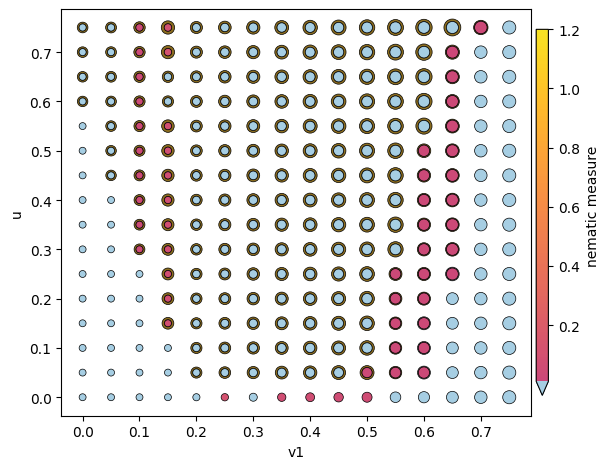

In [63]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

CFG = PlotConfig()
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    v1_mesh, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("v1")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()